In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, LineString
# import itertools
from scipy.interpolate import InterpolatedUnivariateSpline

from load_data import get_pos, get_spikes
from maze_functions import find_zones, trajectory_fields
from plotting_functions import plot_intersects, plot_zone
from decode_functions import get_edges

import vdmlab as vdm

In [ ]:
xy = np.array([[2, 7],
               [4, 5],
               [6, 3],
               [8, 1],
               [2, 4]])
time = np.array([0., 1., 2., 3., 4.])
position = vdm.Position(xy, time)

In [ ]:
plt.plot(position.x, position.y, 'b.', ms=10)
plt.xlim(0.5, 8.5)
plt.ylim(0.5, 7.5)
plt.show()

In [ ]:
spikes = [vdm.SpikeTrain(np.array([3.6, 3.9])), 
          vdm.SpikeTrain(np.array([0., 0., 2.])),
          vdm.SpikeTrain(np.array([2., 2.4]))]

In [ ]:
binsize = 2
xedges = np.arange(position.x.min(), position.x.max()+binsize, binsize)
yedges = np.arange(position.y.min(), position.y.max()+binsize, binsize)

tuning_curves = vdm.tuning_curve_2d(position, spikes, xedges, yedges, sampling_rate=1.)

In [ ]:
plt.figure()
xx, yy = np.meshgrid(xedges, yedges)
for tuning_curve in tuning_curves:
    pp = plt.pcolormesh(xx, yy, tuning_curve, cmap='YlGn')
    plt.colorbar(pp)
    plt.axis('off')
    plt.show()

In [ ]:
counts_binsize = 0.5

time_edges = get_edges(position, counts_binsize, lastbin=True)
counts = vdm.get_counts(spikes, time_edges, apply_filter=False)

In [ ]:
print(time_edges)

In [ ]:
print(counts)

In [ ]:
decoding_tc = []
for tuning_curve in tuning_curves:
    decoding_tc.append(np.ravel(tuning_curve))
decoding_tc = np.array(decoding_tc)

In [ ]:
shape = tuning_curves[0].shape

In [ ]:
tuning_curves

In [ ]:
decoding_tc

In [ ]:
likelihood = vdm.bayesian_prob(counts, decoding_tc, counts_binsize)

In [ ]:
likelihood

In [ ]:
xcenters = (xedges[1:] + xedges[:-1]) / 2.
ycenters = (yedges[1:] + yedges[:-1]) / 2.
xy_centers = vdm.cartesian(xcenters, ycenters)

time_centers = (time_edges[1:] + time_edges[:-1]) / 2.

In [ ]:
time_centers

In [ ]:
decoded = vdm.decode_location(likelihood, xy_centers, time_centers)

In [ ]:
decoded.x, decoded.y, decoded.time

In [ ]:
nan_idx = np.logical_and(np.isnan(decoded.x), np.isnan(decoded.y))
decoded = decoded[~nan_idx]

In [ ]:
decoded.x, decoded.y, decoded.time

In [ ]:
x_spline = InterpolatedUnivariateSpline(position.time, position.x)
y_spline = InterpolatedUnivariateSpline(position.time, position.y)
actual_position = vdm.Position(np.hstack((x_spline(time_centers)[..., np.newaxis],
                                         (y_spline(time_centers)[..., np.newaxis]))), time_centers)

In [ ]:
actual_position.x, actual_position.y, actual_position.time

In [ ]:
error = np.abs(decoded.data - actual_position.data)

In [ ]:
avg_error = np.nanmean(error)
avg_error

## How does the 1D decoding work?

In [ ]:
x = np.array([2, 4, 6, 8, 3])
time = np.array([0., 1., 2., 3., 4.])
position = vdm.Position(x, time)

In [ ]:
spikes = [vdm.SpikeTrain(np.array([3.6, 3.9])), vdm.SpikeTrain(np.array([2.2, 2.43]))]

In [ ]:
pos_binsize = 1
tuning_curves = vdm.tuning_curve(position, spikes, binsize=pos_binsize, sampling_rate=1., gaussian_std=None)

In [ ]:
tuning_curves

In [ ]:
plt.plot(tuning_curves[0], 'b')
plt.plot(tuning_curves[1], 'm')
plt.show()

In [ ]:
counts_binsize = 0.5
time_edges = get_edges(position, counts_binsize, lastbin=True)
counts = vdm.get_counts(spikes, time_edges)

In [ ]:
time_edges.shape

In [ ]:
counts

In [ ]:
likelihood = vdm.bayesian_prob(counts, tuning_curves, counts_binsize)

In [ ]:
likelihood

In [ ]:
pos_edges = vdm.binned_position(position, pos_binsize)
x_centers = (pos_edges[1:] + pos_edges[:-1]) / 2.
x_centers = x_centers[..., np.newaxis]

time_centers = (time_edges[1:] + time_edges[:-1]) / 2.

decoded = vdm.decode_location(likelihood, x_centers, time_centers)
decoded

In [ ]:
nan_idx = np.isnan(decoded.x)
decoded = decoded[~nan_idx]

In [ ]:
decoded.x, decoded.time

In [ ]:
spline = InterpolatedUnivariateSpline(position.time, position.x)
actual_position = vdm.Position(spline(decoded.time), decoded.time)

In [ ]:
actual_position.x, actual_position.time

In [ ]:
error = np.abs(decoded.x - actual_position.x)

In [ ]:
decoded.x, actual_position.x

In [ ]:
avg_error = np.mean(error)
avg_error

# check velocity 1D

In [ ]:
x = np.array([2, 4, 6, 8, 3])
time = np.array([0., 1., 2., 3., 4.])
position = vdm.Position(x, time)

spikes = [vdm.SpikeTrain(np.array([3.6, 3.9])), 
          vdm.SpikeTrain(np.array([2.2, 2.4])),
          vdm.SpikeTrain(np.array([0.6, 0.9])),
          vdm.SpikeTrain(np.array([1., 1.1])), 
          vdm.SpikeTrain(np.array([1.7, 1.9]))]

pos_binsize = 1
tuning_curves = vdm.tuning_curve(position, spikes, binsize=pos_binsize, sampling_rate=1., gaussian_std=None)

counts_binsize = 0.5
time_edges = get_edges(position, counts_binsize, lastbin=True)
counts = vdm.get_counts(spikes, time_edges)

likelihood = vdm.bayesian_prob(counts, tuning_curves, counts_binsize)

pos_edges = vdm.binned_position(position, pos_binsize)
x_centers = (pos_edges[1:] + pos_edges[:-1]) / 2.
x_centers = x_centers[..., np.newaxis]

time_centers = (time_edges[1:] + time_edges[:-1]) / 2.

decoded = vdm.decode_location(likelihood, x_centers, time_centers)

nan_idx = np.isnan(decoded.x)
decoded = decoded[~nan_idx]

print(decoded.x, decoded.time)

In [ ]:
decode_jumps = vdm.remove_teleports(decoded, speed_thresh=0, min_length=1)

In [ ]:
decode_jumps.time, decode_jumps.x

## Counts filtering parameter check

In [ ]:
std = [0.1, 0.025, 0.01, 0.002, None, 0.5, 1.0]
error = [29.9113296726, 29.3032199091, 45.8427697608, 45.8427697608, 45.8427697608, 28.623598705, 29.0339763118]

In [ ]:
plt.plot(std, error, '.', ms=15)
plt.xlim(-0.1, 1.1)
plt.ylim(25, 48)
plt.show()

## Other stuff

In [13]:

from load_data import get_pos, get_spikes, get_lfp

import info.R063d2_info as r063d2
import info.R063d3_info as r063d3
info = r063d2

In [14]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import InterpolatedUnivariateSpline
import random
import seaborn as sns

import vdmlab as vdm

from load_data import get_pos, get_spikes
from maze_functions import find_zones
from tuning_curves_functions import get_tc_1d, find_ideal
from decode_functions import get_edges
from plotting_functions import plot_compare_decoded_track

In [15]:
pickle_filepath = 'C:\\Users\\Emily\\Code\\emi_shortcut\\cache\\pickled\\'
output_filepath = 'C:\\Users\\Emily\\Code\\emi_shortcut\\plots\\'

In [129]:
infos = [r063d2, r063d3]
# infos = [r063d2, r063d3, r063d4, r063d5, r063d6, r066d1, r066d2, r066d3, r066d4, r067d1]

shuffle_id = False

combined_errors = []
combined_actual = dict(u=[], shortcut=[], novel=[], other=[], together=[])
combined_decoded = dict(u=[], shortcut=[], novel=[], other=[], together=[])

for info in infos:
    print(info.session_id)
    position = get_pos(info.pos_mat, info.pxl_to_cm)
    spikes = get_spikes(info.spike_mat)

    speed = position.speed(t_smooth=0.5)
    run_idx = np.squeeze(speed.data) >= info.run_threshold
    run_pos = position[run_idx]

    # track_starts = [info.task_times['phase1'].start, info.task_times['phase2'].start, info.task_times['phase3'].start]
    # track_stops = [info.task_times['phase1'].stop, info.task_times['phase2'].stop, info.task_times['phase3'].stop]

    track_start = info.task_times['phase3'].start
    track_stop = info.task_times['phase3'].stop

    track_pos = run_pos.time_slice(track_start, track_stop)

    track_spikes = [spiketrain.time_slice(track_start, track_stop) for spiketrain in spikes]

    binsize = 3
    xedges = np.arange(track_pos.x.min(), track_pos.x.max() + binsize, binsize)
    yedges = np.arange(track_pos.y.min(), track_pos.y.max() + binsize, binsize)

    tuning_curves = vdm.tuning_curve_2d(track_pos, track_spikes, xedges, yedges, gaussian_sigma=0.1)
    if shuffle_id:
        random.shuffle(tuning_curves)

    counts_binsize = 0.025
    time_edges = get_edges(run_pos, counts_binsize, lastbin=True)
    counts = vdm.get_counts(track_spikes, time_edges, gaussian_std=0.025)

    decoding_tc = []
    for tuning_curve in tuning_curves:
        decoding_tc.append(np.ravel(tuning_curve))
    decoding_tc = np.array(decoding_tc)

    likelihood = vdm.bayesian_prob(counts, decoding_tc, counts_binsize)

    xcenters = (xedges[1:] + xedges[:-1]) / 2.
    ycenters = (yedges[1:] + yedges[:-1]) / 2.
    xy_centers = vdm.cartesian(xcenters, ycenters)

    time_centers = (time_edges[1:] + time_edges[:-1]) / 2.

    decoded = vdm.decode_location(likelihood, xy_centers, time_centers)
    nan_idx = np.logical_and(np.isnan(decoded.x), np.isnan(decoded.y))
    decoded = decoded[~nan_idx]

    if not decoded.isempty:
        decoded = vdm.remove_teleports(decoded, speed_thresh=10, min_length=3)

    actual_x = np.interp(decoded.time, track_pos.time, track_pos.x)
    actual_y = np.interp(decoded.time, track_pos.time, track_pos.y)

    actual_position = vdm.Position(np.hstack((actual_x[..., np.newaxis], actual_y[..., np.newaxis])), decoded.time)

    errors = actual_position.distance(decoded)

    zones = find_zones(info, expand_by=7)
    actual_zones = point_in_zones(actual_position, zones)
    decoded_zones = point_in_zones(decoded, zones)

    combined_errors.append(np.mean(errors))

    combined_actual['u'].append(actual_zones['u'])
    combined_actual['shortcut'].append(actual_zones['shortcut'])
    combined_actual['novel'].append(actual_zones['novel'])
    combined_actual['other'].append(actual_zones['other'])
    combined_actual['together'].append(len(actual_zones['u'].time) + len(actual_zones['shortcut'].time) + 
                                       len(actual_zones['novel'].time) + len(actual_zones['other'].time))

    combined_decoded['u'].append(decoded_zones['u'])
    combined_decoded['shortcut'].append(decoded_zones['shortcut'])
    combined_decoded['novel'].append(decoded_zones['novel'])
    combined_decoded['other'].append(decoded_zones['other'])
    combined_decoded['together'].append(len(decoded_zones['u'].time) + len(decoded_zones['shortcut'].time) +
                                        len(decoded_zones['novel'].time) + len(decoded_zones['other'].time))

R063d2
R063d3


In [111]:
np.mean(combined_actual['u'])

21113.5

In [132]:
keys = ['u', 'shortcut', 'novel', 'other']

actual = dict(u=[], shortcut=[], novel=[], other=[], together=[])
decode = dict(u=[], shortcut=[], novel=[], other=[], together=[])

for key in keys:
    if len(combined_actual[key]) != len(combined_decoded[key]):
        raise ValueError("must have same number of decoded and actual samples")
    for val in range(len(combined_actual[key])):
        actual[key].append(len(combined_actual[key][val].time)/combined_actual['together'][val])
        decode[key].append(len(combined_decoded[key][val].time)/combined_decoded['together'][val])

In [170]:
normalized_actual = dict(u=[], shortcut=[], novel=[], other=[])
normalized_decoded = dict(u=[], shortcut=[], novel=[], other=[])

if len(combined_actual[key]) != len(combined_decoded[key]):
    raise ValueError("must have same number of decoded and actual samples")

n_sessions = len(combined_actual['together'])

for val in range(n_sessions):
    actual = dict()
    decode = dict()
    for key in keys:
        actual[key] = combined_actual[key][val]
        decode[key] = combined_decoded[key][val]
    norm_actual = compare_rates(actual)
    norm_decoded = compare_rates(decode)
    for key in keys:
        normalized_actual[key].append(norm_actual[key])
        normalized_decoded[key].append(norm_decoded[key])

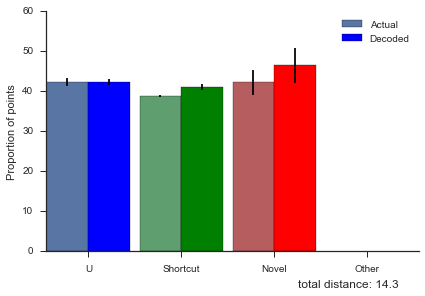

In [171]:
plot_compare_decoded_track(normalized_actual, normalized_decoded, str(round(np.mean(combined_errors), 2)), max_y=60.)

In [135]:
import scipy.stats as stats

In [165]:
def plot_compare_decoded_track(actual, decode, distance, max_y=1., savepath=None, savefig=False):
    """Plots barplot comparing decoded vs. actual position during track times.

    Parameters
    ----------
    actual_zones: dict
        With u, shortcut, novel, other as keys, each a vdmlab.Position object.
    decoded_zones: dict
        With u, shortcut, novel, other as keys, each a vdmlab.Position object.
    distance: str
        Total distance between actual and decoded positions
    savepath : str or None
        Location and filename for the saved plot.

    """

    actual_mean = dict()
    actual_mean['u'] = np.mean(actual['u'])
    actual_mean['shortcut'] = np.mean(actual['shortcut'])
    actual_mean['novel'] = np.mean(actual['novel'])
    actual_mean['other'] = np.mean(actual['other'])

    actual_sem = dict()
    actual_sem['u'] = stats.sem(actual['u'])
    actual_sem['shortcut'] = stats.sem(actual['shortcut'])
    actual_sem['novel'] = stats.sem(actual['novel'])
    actual_sem['other'] = stats.sem(actual['other'])

    decoded_mean = dict()
    decoded_mean['u'] = np.mean(decode['u'])
    decoded_mean['shortcut'] = np.mean(decode['shortcut'])
    decoded_mean['novel'] = np.mean(decode['novel'])
    decoded_mean['other'] = np.mean(decode['other'])

    decoded_sem = dict()
    decoded_sem['u'] = stats.sem(decode['u'])
    decoded_sem['shortcut'] = stats.sem(decode['shortcut'])
    decoded_sem['novel'] = stats.sem(decode['novel'])
    decoded_sem['other'] = stats.sem(decode['other'])

    actual_means = [actual_mean['u'], actual_mean['shortcut'], actual_mean['novel'], actual_mean['other']]
    actual_sems = [actual_sem['u'], actual_sem['shortcut'], actual_sem['novel'], actual_sem['other']]

    decoded_means = [decoded_mean['u'], decoded_mean['shortcut'], decoded_mean['novel'], decoded_mean['other']]
    decoded_sems = [decoded_sem['u'], decoded_sem['shortcut'], decoded_sem['novel'], decoded_sem['other']]

    n_groups = np.arange(4)
    width = 0.45

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(n_groups, actual_means, width, color=['#5975a4', '#5f9e6e', '#b55d5f', '#c51b8A'],
           label='Actual', yerr=actual_sems, ecolor='k')
    ax.bar(n_groups+width, decoded_means, width, color=['b', 'g', 'r', 'm'],
           label='Decoded', yerr=decoded_sems, ecolor='k')
    plt.ylabel('Proportion of points')
    sns.despine()
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(n_groups + width)
    ax.set_xticklabels(['U', 'Shortcut', 'Novel', 'Other'])
    ax.set_ylim(0., max_y)
    ax.text(width*6, max_y*-0.15, 'total distance: ' + distance, fontsize=12)
    plt.legend()
    plt.tight_layout()
    if savefig:
        plt.savefig(savepath, dpi=300)
        plt.close()
    else:

        plt.show()

In [162]:
1 * -0.2

-0.2

In [17]:
from decode_functions import point_in_zones
from shapely.geometry import Point

In [18]:
def point_in_zones(position, zones):
    """Assigns points if contained in shortcut zones

    Parameters
    ----------
    position : vdmlab.Position
    zones : dict
        With u, ushort, unovel, shortcut, shortped, novel, novelped, pedestal as keys

    Returns
    -------
    sorted_zones : dict
        With u, shortcut, novel, other as keys, each a vdmlab.Position object

    """
    u_data = []
    u_times = []
    shortcut_data = []
    shortcut_times = []
    novel_data = []
    novel_times = []
    other_data = []
    other_times = []

    for x, y, time in zip(position.x, position.y, position.time):
        point = Point([x, y])
        if zones['u'].contains(point) or zones['ushort'].contains(point) or zones['unovel'].contains(point):
            u_data.append([x, y])
            u_times.append(time)
            continue
        elif zones['shortcut'].contains(point) or zones['shortped'].contains(point):
            shortcut_data.append([x, y])
            shortcut_times.append(time)
            continue
        elif zones['novel'].contains(point) or zones['novelped'].contains(point):
            novel_data.append([x, y])
            novel_times.append(time)
            continue
        else:
            other_data.append([x, y])
            other_times.append(time)

    sorted_zones = dict()
    sorted_zones['u'] = vdm.Position(u_data, u_times)
    sorted_zones['shortcut'] = vdm.Position(shortcut_data, shortcut_times)
    sorted_zones['novel'] = vdm.Position(novel_data, novel_times)
    sorted_zones['other'] = vdm.Position(other_data, other_times)

    return sorted_zones

In [19]:
zones = find_zones(info, expand_by=7)
actual_zones = point_in_zones(actual_position, zones)
decoded_zones = point_in_zones(decoded, zones)

In [20]:
len(actual_zones['other'].time), len(decoded_zones['other'].time)

(3, 1832)

In [21]:
print(len(decoded.time), len(actual_position.time))

16359 16359


In [99]:
def plot_compare_decoded_track(actual, decode, distance, savepath=None, savefig=True):
    """Plots barplot comparing decoded vs. actual position during track times.

    Parameters
    ----------
    actual_zones: dict
        With u, shortcut, novel, other as keys, each a vdmlab.Position object.
    decoded_zones: dict
        With u, shortcut, novel, other as keys, each a vdmlab.Position object.
    distance: str
        Total distance between actual and decoded positions
    savepath : str or None
        Location and filename for the saved plot.

    """
    actual = [actual['u'], actual['shortcut'], actual['novel'], actual['other']]
    decode = [decode['u'], decode['shortcut'], decode['novel'], decode['other']]

    n_groups = np.arange(4)
    width = 0.45
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(n_groups, actual, width, color=['#5975a4', '#5f9e6e', '#b55d5f', '#c51b8A'], label='Actual')
    ax.bar(n_groups+width, decode, width, color=['b', 'g', 'r', 'm'], label='Decoded')
    plt.ylabel('Proportion of points')
    sns.despine()
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(n_groups + width)
    ax.set_xticklabels(['U', 'Shortcut', 'Novel', 'Other'])
#     ax.set_ylim(0., 1.)
    ax.text(width*5, 0.8, 'total distance: ' + distance, fontsize=12)
    plt.legend()
    plt.tight_layout()
    if savefig:
        plt.savefig(savepath, dpi=300)
        plt.close()
    else:

        plt.show()

In [86]:
total_actual = (len(actual_zones['novel'].time) +
                    len(actual_zones['shortcut'].time) +
                    len(actual_zones['u'].time) +
                    len(actual_zones['other'].time))

total_decoded = (len(decoded_zones['u'].time) +
                 len(decoded_zones['shortcut'].time) +
                 len(decoded_zones['novel'].time) +
                 len(decoded_zones['other'].time))
actual = dict()
actual['u'] = len(actual_zones['u'].time)/total_actual
actual['shortcut'] = len(actual_zones['shortcut'].time)/total_actual
actual['novel'] = len(actual_zones['novel'].time)/total_actual
actual['other'] = len(actual_zones['other'].time)/total_actual

decode = dict()
decode['u'] = len(decoded_zones['u'].time)/total_decoded
decode['shortcut'] = len(decoded_zones['shortcut'].time)/total_decoded
decode['novel'] = len(decoded_zones['novel'].time)/total_decoded
decode['other'] = len(decoded_zones['other'].time)/total_decoded

In [95]:
def compare_rates(zones, jump=0.1):
    """Compare position normalized by time spent in zone.
    
    Parameters
    ----------
    zones: dict
        With u, shortcut, novel, other as keys.
    jump: float
        Any duration above this amount will not be included.
        
    Returns
    -------
    normalized : dict
        With u, shortcut, novel, other as keys.
    
    """
    u_linger = np.diff(zones['u'].time)
    shortcut_linger = np.diff(zones['shortcut'].time)
    novel_linger = np.diff(zones['novel'].time)
    other_linger = np.diff(zones['other'].time)
    
    u_linger = np.sum(u_linger[u_linger < jump])
    shortcut_linger = np.sum(shortcut_linger[shortcut_linger < jump])
    novel_linger = np.sum(novel_linger[novel_linger < jump])
    other_linger = np.sum(other_linger[other_linger < jump])

    normalized = dict()
    normalized['u'] = len(zones['u'].time) / u_linger
    normalized['shortcut'] = len(zones['shortcut'].time) / shortcut_linger
    normalized['novel'] = len(zones['novel'].time) / novel_linger
    if len(zones['other'].time) > 20:
        normalized['other'] = len(zones['other'].time) / other_linger
    else:
        normalized['other'] = np.nan
    
    return normalized

In [96]:
decode = compare_rates(decoded_zones)

print('u:', decode['u'])
print('shortcut:', decode['shortcut'])
print('novel:', decode['novel'])
print('other:', decode['other'])

u: 42.9588087411
shortcut: 41.6065911432
novel: 50.8143322476
other: 48.0524590165


In [97]:
actual = compare_rates(actual_zones)

print('u:', actual['u'])
print('shortcut:', actual['shortcut'])
print('novel:', actual['novel'])
print('other:', actual['other'])

u: 43.3074617691
shortcut: 38.8910133844
novel: 45.2427184467
other: nan


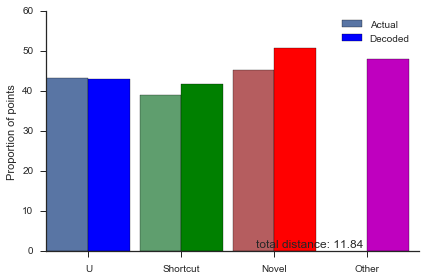

In [100]:
plot_compare_decoded_track(actual, decode, str(round(np.mean(errors), 2)), savefig=False)

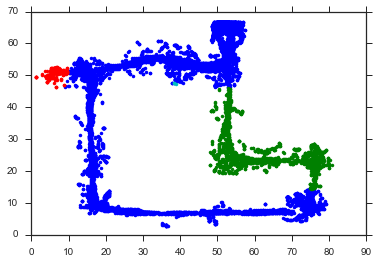

In [23]:
plt.plot(actual_zones['u'].x, actual_zones['u'].y, 'b.')
plt.plot(actual_zones['shortcut'].x, actual_zones['shortcut'].y, 'g.')
plt.plot(actual_zones['novel'].x, actual_zones['novel'].y, 'r.')
plt.plot(actual_zones['other'].x, actual_zones['other'].y, 'c.')
plt.show()

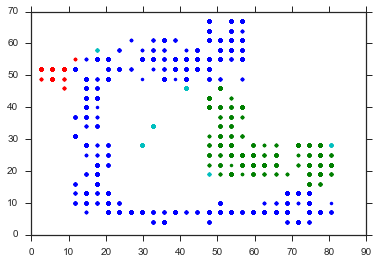

In [24]:
plt.plot(decoded_zones['u'].x, decoded_zones['u'].y, '.', color='b')
plt.plot(decoded_zones['shortcut'].x, decoded_zones['shortcut'].y, '.', color='g')
plt.plot(decoded_zones['novel'].x, decoded_zones['novel'].y, '.', color='r')
plt.plot(decoded_zones['other'].x, decoded_zones['other'].y, '.', color='c')
plt.show()

In [ ]:
actual = [11.84, 16.73, 14.19, 5.20, 7.10, 8.79, 8.23, 10.16, 9.22, 13.20, 21.13, 11.32, 20.54, 17.58, 17.63, 7.79, 7.66, 22.53, ]

In [ ]:
import numpy as np
np.mean(actual)

In [ ]:
std = 24
test_xy = actual_position.data + np.random.normal(0, std, actual_position.data.shape)
test_pos = vdm.Position(test_xy, actual_position.time)
test_errors = actual_position.distance(test_pos)
print('Test distance:', np.mean(test_errors))

In [ ]:
difference = 32
test_xy = actual_position.data + difference
test_pos = vdm.Position(test_xy, actual_position.time)
test_errors = actual_position.distance(test_pos)
print('Test distance:', np.mean(test_errors))

In [ ]:
plt.plot(test_pos.x, test_pos.y, 'm.', ms=1)
plt.plot(actual_position.x, actual_position.y, 'b.')
plt.show()

In [ ]:
plt.boxplot(errors)
plt.show()

In [ ]:
from scipy.interpolate import InterpolatedUnivariateSpline

In [ ]:
x = np.linspace(-np.pi, np.pi, 10)
y = np.sin(x)

In [ ]:
plt.plot(x, y)
plt.show()

In [ ]:
spline = InterpolatedUnivariateSpline(x, y)
xs = np.linspace(-np.pi, np.pi, 100)
plt.plot(xs, spline(xs), 'g')
plt.show()

In [ ]:
spline.get_residual()

## Smoothing parameter check r063d3

In [8]:
results = [45.848643426859908, 29.302109714304461, 29.865521819738152, 29.913643399713909, 
           29.31095963377842, 28.624072044945866, 29.030549355726453, 30.077038030159233, 
           35.687684936555392, 45.848643426859908, 29.302109714304461, 29.865521819738152, 
           29.913643399713909, 29.31095963377842, 28.624072044945866, 29.030549355726453, 
           30.077038030159233, 35.687684936555392, 45.837111423306133, 29.298067119359189, 
           29.865976461880123, 29.906030473851345, 29.315789159414265, 28.624741085514444, 
           29.038110154705642, 30.079648033878346, 35.671749554313877, 31.61798486482013, 
           28.246634578841597, 29.647769711117515, 29.759165760476954, 29.411293543594194, 
           29.032704072802389, 29.042793425889936, 30.065880405200712, 35.645934498839758, 
           35.53800513968023, 28.658373941308831, 29.9207542421798, 29.708641610463751, 
           29.15494984997331, 28.578793132568546, 27.936605145242357, 29.258432270602221, 
           36.575977104419799, 36.941733764866761, 28.565957749459606, 31.102959353810512, 
           31.652782412930737, 31.239089639161165, 30.370535330601069, 30.036002190935022, 
           30.47971725975156, 34.304025317596022, 42.40508424723307, 36.370085788326456, 
           35.665673178845203, 35.775161545441925, 35.072970980897509, 33.78477541516596, 
           32.971823463940467, 32.494082917186063, 36.476158353888927, 45.262874125229665, 
           39.137571198808182, 38.514080294292121, 38.145109980432188, 37.304017745509341, 
           36.004485787827981, 34.679346348606181, 34.496813560336243, 39.817394108676588, 
           46.179512100491614, 43.733904525349814, 43.343444851581296, 42.579898778998576, 
           41.358252936093763, 39.791099877994974, 37.98070494210117, 36.890839324932948, 
           40.813685068781943, 49.4741802086211, 48.591570003593411, 47.833202625053076, 
           46.995084807712587, 46.078177190708551, 44.893523028409724, 43.235332282122172, 
           41.63670146397692, 42.87855295235785]

In [9]:
# [position, time]
inputs = [[None, None], [None, 0.025], [None, 0.05], [None, 0.1], [None, 0.2], [None, 0.5], 
          [None, 1.0], [None, 2.0], [None, 5.0], [0.1, None], [0.1, 0.025], [0.1, 0.05], 
          [0.1, 0.1], [0.1, 0.2], [0.1, 0.5], [0.1, 1.0], [0.1, 2.0], [0.1, 5.0], [0.25, None], 
          [0.25, 0.025], [0.25, 0.05], [0.25, 0.1], [0.25, 0.2], [0.25, 0.5], [0.25, 1.0], 
          [0.25, 2.0], [0.25, 5.0], [0.5, None], [0.5, 0.025], [0.5, 0.05], [0.5, 0.1], [0.5, 0.2], 
          [0.5, 0.5], [0.5, 1.0], [0.5, 2.0], [0.5, 5.0], [1.0, None], [1.0, 0.025], [1.0, 0.05], 
          [1.0, 0.1], [1.0, 0.2], [1.0, 0.5], [1.0, 1.0], [1.0, 2.0], [1.0, 5.0], [3.0, None], 
          [3.0, 0.025], [3.0, 0.05], [3.0, 0.1], [3.0, 0.2], [3.0, 0.5], [3.0, 1.0], [3.0, 2.0], 
          [3.0, 5.0], [5.0, None], [5.0, 0.025], [5.0, 0.05], [5.0, 0.1], [5.0, 0.2], [5.0, 0.5], 
          [5.0, 1.0], [5.0, 2.0], [5.0, 5.0], [7.5, None], [7.5, 0.025], [7.5, 0.05], [7.5, 0.1], 
          [7.5, 0.2], [7.5, 0.5], [7.5, 1.0], [7.5, 2.0], [7.5, 5.0], [10.0, None], [10.0, 0.025], 
          [10.0, 0.05], [10.0, 0.1], [10.0, 0.2], [10.0, 0.5], [10.0, 1.0], [10.0, 2.0], [10.0, 5.0], 
          [15.0, None], [15.0, 0.025], [15.0, 0.05], [15.0, 0.1], [15.0, 0.2], [15.0, 0.5], 
          [15.0, 1.0], [15.0, 2.0], [15.0, 5.0]]

In [ ]:
results = np.array(results)
inputs = np.array(inputs)

In [ ]:
np.where(results == min(results))

In [11]:
val = 10
inputs[val], results[val]

([0.1, 0.025], 29.30210971430446)

In [12]:
val = 19
inputs[val], results[val]

([0.25, 0.025], 29.29806711935919)

In [ ]:
val = 28
inputs[val], results[val]

In [ ]:
inputs[42]

In [ ]:
inputs[10]

In [ ]:
results[10]

## Smoothing parameter check r063d2

In [2]:
# [time, position]
inputs = [[None, None], [None, 0.1], [None, 0.25], [None, 0.5], [None, 1.0], [None, 3.0], [None, 5.0], [None, 7.5], 
          [None, 10.0], [None, 15.0], [0.025, None], [0.025, 0.1], [0.025, 0.25], [0.025, 0.5], [0.025, 1.0], [0.025, 3.0], 
          [0.025, 5.0], [0.025, 7.5], [0.025, 10.0], [0.025, 15.0], [0.05, None], [0.05, 0.1], [0.05, 0.25], [0.05, 0.5], 
          [0.05, 1.0], [0.05, 3.0], [0.05, 5.0], [0.05, 7.5], [0.05, 10.0], [0.05, 15.0], [0.1, None], [0.1, 0.1], [0.1, 0.25], 
          [0.1, 0.5], [0.1, 1.0], [0.1, 3.0], [0.1, 5.0], [0.1, 7.5], [0.1, 10.0], [0.1, 15.0], [0.2, None], [0.2, 0.1], 
          [0.2, 0.25], [0.2, 0.5], [0.2, 1.0], [0.2, 3.0], [0.2, 5.0], [0.2, 7.5], [0.2, 10.0], [0.2, 15.0], [0.5, None], 
          [0.5, 0.1], [0.5, 0.25], [0.5, 0.5], [0.5, 1.0], [0.5, 3.0], [0.5, 5.0], [0.5, 7.5], [0.5, 10.0], [0.5, 15.0], 
          [1.0, None], [1.0, 0.1], [1.0, 0.25], [1.0, 0.5], [1.0, 1.0], [1.0, 3.0], [1.0, 5.0], [1.0, 7.5], [1.0, 10.0], 
          [1.0, 15.0], [2.0, None], [2.0, 0.1], [2.0, 0.25], [2.0, 0.5], [2.0, 1.0], [2.0, 3.0], [2.0, 5.0], [2.0, 7.5], 
          [2.0, 10.0], [2.0, 15.0], [5.0, None], [5.0, 0.1], [5.0, 0.25], [5.0, 0.5], [5.0, 1.0], [5.0, 3.0], [5.0, 5.0], 
          [5.0, 7.5], [5.0, 10.0], [5.0, 15.0]]

In [5]:
nan = np.nan
results = [35.231131061040671, 23.993012240227859, 24.958608788951562, 31.614563956638591, 30.060249486997485, nan, nan, 
          nan, nan, nan, 35.231131061040671, 23.993012240227859, 24.958608788951562, 31.614563956638591, 30.060249486997485, 
          nan, nan, nan, nan, nan, 35.231131061040671, 23.993012240227859, 24.958608788951562, 31.614563956638591, 
          30.060249486997485, nan, nan, nan, nan, nan, 35.231131061040671, 23.993012240227859, 24.958608788951562, 
          31.614563956638591, 30.060249486997485, nan, nan, nan, nan, nan, 35.243167496690631, 23.986385402892175, 
          24.958608788951562, 31.614563956638591, 30.060249486997485, nan, nan, nan, nan, nan, 36.687684162561489, 
          24.21184241467045, 25.081955729791964, 31.578593802111705, 29.904358245378063, nan, nan, nan, nan, nan, 
          36.465090354168112, 25.046352066083077, 26.493514951760506, 35.573266532195376, 43.974389805212944, nan, nan, 
          nan, nan, nan, 40.526575334651049, 27.200979868403344, 27.630098744507702, 40.861532245914212, 42.532905903890416, 
          nan, nan, nan, nan, nan, 39.691876087341186, 32.640087276459617, 32.217219984902279, 44.092366863934338, 
          52.264811100872024, nan, nan, nan, nan, nan]

In [7]:
results[12]

24.95860878895156

## Other

In [ ]:
pos = np.random.rand(20, 2)

In [ ]:
pos

In [ ]:
split_idx = np.array([4, 6, 10])

In [ ]:
all_idx = [idx for idx in np.split(np.arange(pos.shape[0]), split_idx) if idx.size > 3]

In [ ]:
pos[np.hstack(all_idx)]

In [ ]:
time = np.linspace(0, np.pi*2, 201)
data = np.hstack((np.sin(time)))

In [ ]:
plt.plot(time, data, '.')
plt.show()

In [ ]:
position = vdm.Position(data, time)

In [ ]:
speed = position.speed()

In [ ]:
plt.plot(speed.time, speed.data)
plt.show()

In [ ]:
run_idx = np.squeeze(speed.data) >= 0.5

In [ ]:
run_idx

In [ ]:
position = vdm.Position(data, time)
speed = position.speed()
run_idx = np.squeeze(speed.data) >= 0.7
run_position = position[run_idx]

len(run_position.x)

In [ ]:
assert np.allclose(len(run_position.x), 100)

In [ ]:
velocity = self[1:].distance(self[:-1])
velocity /= np.diff(self.time)
velocity = np.hstack(([0], velocity))

if t_smooth is not None:
    dt = np.median(np.diff(self.time))
    filter_length = np.ceil(t_smooth / dt)
    velocity = np.convolve(velocity, np.ones(int(filter_length))/filter_length, 'same')

return AnalogSignal(velocity, self.time)

In [ ]:
t_smooth=0.5
velocity = np.diff(np.squeeze(position.data))
velocity /= np.diff(position.time)
velocity = np.hstack(([0], velocity))

dt = np.median(np.diff(position.time))
filter_length = np.ceil(t_smooth / dt)
velocity = np.convolve(velocity, np.ones(int(filter_length))/filter_length, 'same')

In [ ]:
velocity

In [ ]:
a = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
a

In [ ]:
np.hstack((a[0:2], a[6:8]))

In [ ]:
indices = []
for t_start, t_stop in zip(np.array([0, 6]), np.array([2, 8])):
    indices.append((a >= t_start) & (a <= t_stop))
indices = np.any(np.column_stack((indices)),axis=1)
a[indices]

In [ ]:
res = np.any(np.column_stack((indices)),axis=1)
res

In [ ]:
spikes = [vdm.SpikeTrain(np.array([0., 0., 1.])), vdm.SpikeTrain(np.array([3.6, 3.9]))]

In [ ]:
one_line = LineString([[2, 0], [2, 2], [2, 4], [2, 6], [2, 8], [2, 10]])

one_start = Point([2, 2])
one_stop = Point([2, 8])

expand_by = 1

one_zone = vdm.expand_line(one_start, one_stop, one_line, expand_by)

In [ ]:
this_idx = []
for pos_idx in range(len(position.time)):
    point = Point([position.x[pos_idx], position.y[pos_idx]])
    if one_zone.contains(point):
        this_idx.append(pos_idx)
        
this_pos = position[this_idx]
linear = this_pos.linearize(one_line, one_zone)

In [ ]:
linear.x

In [ ]:
plt.plot(position.x, position.y, 'g.', ms=10)
# plt.plot([2, 4, 2], [7, 5, 4], 'm.', ms=20)
plt.plot([2, 6], [4, 3], 'm.', ms=20)
plt.plot(one_zone.exterior.xy[0], one_zone.exterior.xy[1], 'b', lw=1)
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.show()

In [ ]:
def expand_line(start_pt, stop_pt, line, expand_by):
    line_expanded = line.buffer(expand_by)
    zone = start_pt.union(line_expanded).union(stop_pt)
    
    return zone

def find_zones(info, expand_by=6):
    u_line = LineString(info.u_trajectory)
    shortcut_line = LineString(info.shortcut_trajectory)
    novel_line = LineString(info.novel_trajectory)

    u_start = Point(info.u_trajectory[0])
    u_stop = Point(info.u_trajectory[-1])
    shortcut_start = Point(info.shortcut_trajectory[0])
    shortcut_stop = Point(info.shortcut_trajectory[-1])
    novel_start = Point(info.novel_trajectory[0])
    novel_stop = Point(info.novel_trajectory[-1])
    pedestal_center = Point(info.path_pts['pedestal'][0], info.path_pts['pedestal'][1])
    pedestal = pedestal_center.buffer(expand_by*2.2)

    zone = dict()
    zone['u'] = expand_line(u_start, u_stop, u_line, expand_by)
    zone['shortcut'] = expand_line(shortcut_start, shortcut_stop, shortcut_line, expand_by)
    zone['novel'] = expand_line(novel_start, novel_stop, novel_line, expand_by)
    zone['ushort'] = zone['u'].intersection(zone['shortcut'])
    zone['unovel'] = zone['u'].intersection(zone['novel'])
    zone['uped'] = zone['u'].intersection(pedestal)
    zone['shortped'] = zone['shortcut'].intersection(pedestal)
    zone['novelped'] = zone['novel'].intersection(pedestal)
    zone['pedestal'] = pedestal
    
    return zone

In [ ]:
def trajectory_fields(tuning_curves, zone, xedges, yedges, field_thresh):
    
    xcenters = np.array((xedges[1:] + xedges[:-1]) / 2.)
    ycenters = np.array((yedges[1:] + yedges[:-1]) / 2.)
    
    tuning_points = []
    for i in itertools.product(ycenters, xcenters):
        tuning_points.append(i)
    tuning_points = np.array(tuning_points)

    this_neuron = 0
    fields_tc = dict(u=[], shortcut=[], novel=[], pedestal=[])
    fields_neuron = dict(u=[], shortcut=[], novel=[], pedestal=[])
    for neuron_tc in tuning_curves:
        this_neuron += 1
        field_idx = neuron_tc.flatten() > field_thresh
        field = tuning_points[field_idx]
        for pt in field:
            point = Point([pt[0], pt[1]])
            if zone['u'].contains(point) or zone['ushort'].contains(point) or zone['unovel'].contains(point):
                if this_neuron not in fields_neuron['u']:
                    fields_tc['u'].append(neuron_tc)
                    fields_neuron['u'].append(this_neuron)
            if zone['shortcut'].contains(point) or zone['shortped'].contains(point):
                if this_neuron not in fields_neuron['shortcut']:
                    fields_tc['shortcut'].append(neuron_tc)
                    fields_neuron['shortcut'].append(this_neuron)
            if zone['novel'].contains(point) or zone['novelped'].contains(point):
                if this_neuron not in fields_neuron['novel']:
                    fields_tc['novel'].append(neuron_tc)
                    fields_neuron['novel'].append(this_neuron)
            if zone['pedestal'].contains(point):
                if this_neuron not in fields_neuron['pedestal']:
                    fields_tc['pedestal'].append(neuron_tc)
                    fields_neuron['pedestal'].append(this_neuron)
                
    return fields_tc

In [ ]:
import sys
# sys.path.append('C:\\Users\\Emily\\Code\\emi_shortcut\\info')
sys.path.append('E:\\code\\emi_shortcut\\info')
import info.R063d3_info as r063d3
info = r063d3

In [ ]:
pickle_filepath = 'E:\\code\\emi_shortcut\\cache\\pickled'
# pickle_filepath = 'C:\\Users\\Emily\\Code\\emi_shortcut\\cache\\pickled'

In [ ]:
position = get_pos(info.pos_mat, info.pxl_to_cm)
spikes = get_spikes(info.spike_mat)

In [ ]:
binsize = 3
xedges = np.arange(position.x.min(), position.x.max()+binsize, binsize)
yedges = np.arange(position.y.min(), position.y.max()+binsize, binsize)

speed = position.speed(t_smooth=0.5)
run_idx = np.squeeze(speed.data) >= info.run_threshold
run_pos = position[run_idx]

t_start = info.task_times['phase3'].start
t_stop = info.task_times['phase3'].stop

sliced_pos = run_pos.time_slice(t_start, t_stop)

sliced_spikes = [spiketrain.time_slice(t_start, t_stop) for spiketrain in spikes]

tuning_curves = vdm.tuning_curve_2d(sliced_pos, sliced_spikes, xedges, yedges, gaussian_sigma=0.2)

In [ ]:
zones = find_zones(info)

In [ ]:
type(zones['u'])

In [ ]:
fields_tc = trajectory_fields(tuning_curves, zones, xedges, yedges, field_thresh=5)

In [ ]:
print(len(fields_tc['novel']))

In [ ]:
tuning_curves[5]

In [ ]:
plt.figure()
xx, yy = np.meshgrid(xedges, yedges)
for tuning_curve in fields_tc['novel']:
    pp = plt.pcolormesh(xx, yy, tuning_curve, cmap='YlGn')
    plt.colorbar(pp)
    plt.axis('off')
    plt.show()